**AI & Machine Learning (KAN-CINTO4003U) - Copenhagen Business School | Spring 2025**

***

# Part II: Agents

Please see the description of the assignment in the README file (section 1) <br>
**Guide notebooks**: [guides/router_agents_guide.ipynb](guides/agents_guide.ipynb) and [guides/tool_agents_guide.ipynb](guides/tool_agents_guide.ipynb)


***
<br>

* Play around with the agent systems in the guides. Maybe try to create a similar system with new nodes? Or you can try to add new tools to the existing tool-using agent system.

* Remember to include some reflections on your results. Are there, for example, any hyperparameters that are particularly important?

* You should follow the steps given in the `router_agents_guide` notebook or the `tool_agents_guide` notebook to create your own agent system - or try to optimize the existing ones.

<br>

***

#### In this notebook, we will be building a router agent

### 1. Imports & Environment Set up

In [1]:
# Built-in types
from typing import Literal, TypedDict, Any

# LangGraph / LangChain
from langgraph.graph import StateGraph, START, END
from langchain_core.runnables.graph import MermaidDrawMethod

# Evaluation & misc
from pydantic import Field
from decouple import Config, RepositoryEnv
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from IPython.display import Image
from tqdm.notebook import tqdm
import os
import sys

# Load .env config
env_path = os.path.join("C:", os.sep, "Users", "louft", "OneDrive", "Desktop", "MBA",
                        "05-HIV25", "AI_and_ML", "AIML25", "mas", "ma3", ".env")
config = Config(repository=RepositoryEnv(env_path))

WX_API_KEY = config("WX_API_KEY")
WX_PROJECT_ID = config("WX_PROJECT_ID")
WX_API_URL = config("WX_API_URL", default="https://us-south.ml.cloud.ibm.com")

# Local modules
sys.path.append("..")
from src.llm import LLMCaller
from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenParams


### 2. Model Setup

In [9]:
model = LLMCaller(
    api_key=WX_API_KEY,
    project_id=WX_PROJECT_ID,
    api_url=WX_API_URL,
    model_id="watsonx/ibm/granite-3-2-8b-instruct",
    params={
        GenParams.TEMPERATURE: 0.3,
        GenParams.MAX_NEW_TOKENS: 512,
        GenParams.REPETITION_PENALTY: 1.1,
        GenParams.TOP_K: 50,
        GenParams.TOP_P: 0.9
    }
)


### 3. State Definition

In [10]:
class EmailState(TypedDict, total=False):
    email: dict[str, Any]
    email_category: Literal["Transactional", "Marketing", "Relational", "Administrative", "Security/alert", "Spam"]
    spam_reason: str
    is_spam: bool
    draft: str
    verbose: bool

### 4. Node Functions

In [11]:
def read_email(state: EmailState):
    email = state["email"]
    if state.get("verbose", False):
        print(f"Reading email from: {email['sender']}")
        print(f"Subject: {email['subject']}")
    return {}

def classify_email(state: EmailState):
    email = state["email"]
    prompt = f"""
You are an assistant that classifies emails.

Tasks:
1. Decide whether the email is spam.
2. If spam, explain why.
3. If not, categorize it using one of the following:

Categories:
- Transactional
- Marketing
- Relational
- Administrative
- Security/alert

Email:
From: {email['sender']}
Subject: {email['subject']}
Body: {email['body']}

Output:
- is_spam: true or false
- spam_reason: explanation
- email_category: one of the above, or 'Spam' if applicable
"""
    response_model = model.create_response_model(
        "EmailAnalysis",
        {
            "spam_reason": (str, Field(description="Explanation for spam or not spam.")),
            "is_spam": (bool, Field(description="Whether the email is spam.")),
            "email_category": (
                Literal["Transactional", "Marketing", "Relational", "Administrative", "Security/alert", "Spam"],
                Field(description="Email category.")
            )
        }
    )
    response = model.invoke(prompt, response_model=response_model)
    return {
        "is_spam": response.is_spam,
        "spam_reason": response.spam_reason,
        "email_category": response.email_category
    }

def handle_spam(state: EmailState):
    if state.get("verbose", False):
        print(f"Email classified as spam. Reason: {state['spam_reason']}")
        print("Email moved to spam folder.")
    return {}

def draft_response(state: EmailState):
    email = state["email"]
    category = state.get("email_category", "General")
    prompt = f"""
You are a professional email assistant.

Based on the following email, draft a short and professional response. The response will be reviewed before sending.

Email category: {category}

Email content:
From: {email['sender']}
Subject: {email['subject']}
Body: {email['body']}
"""
    response = model.invoke(prompt)
    return {"draft": response.answer}

def notify(state: EmailState):
    email = state["email"]
    if state.get("verbose", False):
        print("=" * 60)
        print(f"Email from: {email['sender']}")
        print(f"Subject: {email['subject']}")
        print(f"Category: {state['email_category']}")
        print("Draft response:")
        print("-" * 60)
        print(state["draft"])
        print("=" * 60)
    return {}

def route_email(state: EmailState) -> str:
    is_spam = state.get("is_spam")
    if is_spam is True:
        return "spam"
    elif is_spam is False:
        return "legitimate"
    else:
        raise ValueError("Missing classification result (is_spam).")


### 5. Build the LangGraph

In [12]:
email_graph = StateGraph(EmailState)

email_graph.add_node("read_email", read_email)
email_graph.add_node("classify_email", classify_email)
email_graph.add_node("handle_spam", handle_spam)
email_graph.add_node("draft_response", draft_response)
email_graph.add_node("notify", notify)

email_graph.add_edge(START, "read_email")
email_graph.add_edge("read_email", "classify_email")

email_graph.add_conditional_edges(
    "classify_email",
    route_email,
    {
        "spam": "handle_spam",
        "legitimate": "draft_response"
    }
)

email_graph.add_edge("handle_spam", "notify")
email_graph.add_edge("draft_response", "notify")
email_graph.add_edge("notify", END)

email_graph.set_entry_point("read_email")
email_graph.set_finish_point("notify")

compiled_graph = email_graph.compile()


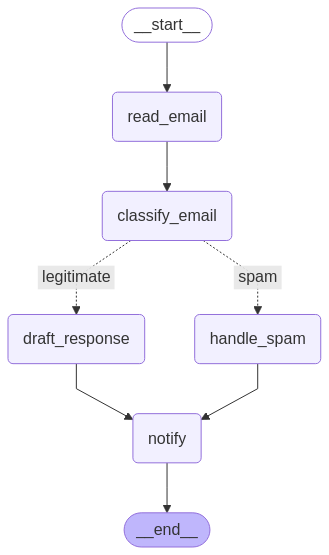

In [ ]:
Image(compiled_graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API))

### 6. Evaluation

In [13]:
legitimate_emails = [
    {
        "sender": "sarah.johnson@acme-corp.com",
        "subject": "Meeting agenda for Thursday",
        "body": "Hi team, Attached is the agenda for our quarterly review meeting on Thursday at 2 PM. Please review the attached documents before we meet. Let me know if you have any questions. Best, Sarah",
        "is_spam": False,
        "category": "Administrative"
    },
    {
        "sender": "tech-support@cloudservices.net",
        "subject": "Your support ticket #45928 has been resolved",
        "body": "Dear valued customer, We're pleased to inform you that your recent support ticket regarding login issues has been resolved. If you continue to experience problems, please reply to this email with ticket #45928 in the subject line. Thank you for your patience. - Cloud Services Support Team",
        "is_spam": False,
        "category": "Transactional"
    },
    {
        "sender": "notifications@linkedin.com",
        "subject": "Michael Chen has endorsed you for Project Management",
        "body": "Hi Alex, Michael Chen has endorsed you for Project Management on LinkedIn. View your profile to see your endorsements and send a thank you note to Michael.",
        "is_spam": False,
        "category": "Relational"
    },
    {
        "sender": "reservation@grandhotel.com",
        "subject": "Confirmation: Your stay on March 5-7, 2025",
        "body": "Dear Ms. Williams, This email confirms your reservation at Grand Hotel for March 5-7, 2025. Check-in: 3 PM, Check-out: 11 AM. Reservation #: GH-789456. We look forward to welcoming you. For changes, please call 555-123-4567. Sincerely, Grand Hotel Reservations",
        "is_spam": False,
        "category": "Transactional"
    },
    {
        "sender": "david.wilson@partnercompany.org",
        "subject": "Proposal draft and timeline",
        "body": "Hi Jessica, As discussed in our call yesterday, I've attached the draft proposal and project timeline for your review. Please let me know if you'd like any changes before we present this to the board next week. Regards, David",
        "is_spam": False,
        "category": "Relational"
    },
    {
        "sender": "newsletter@industry-insights.com",
        "subject": "March 2025 Newsletter: Industry Trends and Analysis",
        "body": "Industry Insights Newsletter - March 2025 | Featured Article: The Impact of AI on Manufacturing | Upcoming Webinar: Supply Chain Optimization Strategies | Market Analysis: Q1 Reports | To unsubscribe, click here",
        "is_spam": False,
        "category": "Marketing"
    },
    {
        "sender": "laura.santos@freelance-writer.me",
        "subject": "Invoice #113 for content writing services",
        "body": "Dear Mr. Reynolds, Please find attached invoice #113 for the content writing services provided in February 2025. Payment terms are net 30 days as per our agreement. Thank you for your business. Best regards, Laura Santos",
        "is_spam": False,
        "category": "Transactional"
    },
    {
        "sender": "no-reply@amazon.com",
        "subject": "Your Amazon order #112-7366425-8795621 has shipped",
        "body": "Your package is on its way! Your order of 'Wireless Headphones' has shipped and is expected to arrive on Tuesday, April 2. Track your package: https://amazon.com/track/112-7366425-8795621",
        "is_spam": False,
        "category": "Transactional"
    },
    {
        "sender": "alumni@university.edu",
        "subject": "Annual Alumni Fundraising Event - Save the Date",
        "body": "Dear Alumni, We're excited to announce our Annual Fundraising Gala will take place on May 15, 2025, at the University Grand Hall. This year's theme is 'Building Tomorrow's Leaders'. Early bird tickets available until April 10. More details to follow. University Alumni Association",
        "is_spam": False,
        "category": "Marketing"
    },
    {
        "sender": "hr@currentemployer.com",
        "subject": "Important: Benefits enrollment period ending soon",
        "body": "Reminder: The annual benefits enrollment period ends on April 10, 2025. Please log in to the HR portal to review and confirm your selections for the upcoming fiscal year. If no changes are made, your current selections will roll over. Human Resources Department",
        "is_spam": False,
        "category": "Administrative"
    }
]

spam_emails = [
    {
        "sender": "security-alert@bankofamerica-secure.info",
        "subject": "Urgent: Your account has been limited",
        "body": "Dear valued customer, We have detected suspicious activity on your account. Your access has been limited for security reasons. Please verify your identity by clicking this link immediately: http://secure-bankofamerica.info/verify",
        "is_spam": True,
        "category": "Spam"
    },
    {
        "sender": "employment@career-opportunity.net",
        "subject": "Make $5000/week working from home!",
        "body": "AMAZING OPPORTUNITY! We're looking for serious people who want to earn $5000+ per week working just 2 hours per day from home! No experience needed! Limited positions available! Reply NOW with your name and phone number to secure your spot!",
        "is_spam": True,
        "category": "Spam"
    },
    {
        "sender": "prince.nelson@royalfamily-intl.org",
        "subject": "Confidential Business Proposal",
        "body": "Dear Friend, I am Prince Nelson from the Royal Family of Wakanda. I need to transfer $25,000,000 out of my country and require your assistance. In return, you will receive 30% of the funds. Please reply with your bank details to proceed with this transaction. Regards, Prince Nelson",
        "is_spam": True,
        "category": "Spam"
    },
    {
        "sender": "billing@netflix-accounts.com",
        "subject": "Netflix Payment Failed - Update Information",
        "body": "Dear Customer, Your Netflix payment method has expired. To avoid service interruption, please update your payment information immediately: http://netflix-account-verify.com/login",
        "is_spam": True,
        "category": "Spam"
    },
    {
        "sender": "pharmacy-discounts@medstore24.biz",
        "subject": "70% OFF Premium Medications - No Prescription Needed!",
        "body": "HUGE PHARMACEUTICAL SALE! Get premium medications at 70% OFF regular prices! No prescription required! Overnight shipping available! Viagra, Cialis, Weight Loss Pills, Pain Relief, and more! Order now at www.medstore24.biz",
        "is_spam": True,
        "category": "Spam"
    },
    {
        "sender": "customer-service@apple.id-verify.com",
        "subject": "Your Apple ID was used to sign in on a new device",
        "body": "Dear Customer, Your Apple ID was recently used to sign in on an unknown device in Kyiv, Ukraine. If this wasn't you, your account may be compromised. Secure your account now: https://apple-id-verification.com/secure",
        "is_spam": True,
        "category": "Spam"
    },
    {
        "sender": "irs.refunds@tax-return-service.org",
        "subject": "IRS: You have a tax refund pending",
        "body": "ATTENTION: The Internal Revenue Service has calculated your tax return and determined you are eligible for an additional refund of $1,427.89. To claim your refund, click here to verify your identity and provide your direct deposit information: https://irs-tax-refunds.org/claim",
        "is_spam": True,
        "category": "Spam"
    },
    {
        "sender": "james.wilson@businessproposal.co",
        "subject": "Re: Our discussion last week",
        "body": "Hello, Following up on our discussion last week regarding the investment opportunity. As I mentioned, this is a limited-time offer with 300% guaranteed returns within 3 months. Minimum investment is only $1000. Let me know if you're ready to proceed. James Wilson, Investment Specialist",
        "is_spam": True,
        "category": "Spam"
    },
    {
        "sender": "track-delivery@fedex-shipping.info",
        "subject": "FedEx: Your package delivery status",
        "body": "Notification: We attempted to deliver your package today but were unable to due to an incorrect address. To reschedule delivery, please confirm your details here: http://fedex-delivery-reschedule.info/form. Reference: FDX-78542136",
        "is_spam": True,
        "category": "Spam"
    },
    {
        "sender": "support@microsoft-security-team.net",
        "subject": "Critical Windows Security Alert - Immediate Action Required",
        "body": "WARNING: Your Windows computer has been infected with dangerous malware that is stealing your personal information. Our security scan detected 13 viruses on your system. Download and run our free security tool immediately to remove these threats: www.microsoft-security-scan.net/download",
        "is_spam": True,
        "category": "Spam"
    }
]

In [14]:
def evaluate_email_classifications(ground_truth, predictions):
    true_spam = [email["is_spam"] for email in ground_truth]
    pred_spam = [pred["is_spam"] for pred in predictions]

    return {
        "f1_score": f1_score(true_spam, pred_spam),
        "accuracy": accuracy_score(true_spam, pred_spam),
        "precision": precision_score(true_spam, pred_spam),
        "recall": recall_score(true_spam, pred_spam),
    }

ground_truth = legitimate_emails + spam_emails
predictions = []

for email in tqdm(ground_truth, desc="Evaluating emails"):
    result = compiled_graph.invoke({"email": email, "verbose": False})
    predictions.append({"is_spam": result["is_spam"]})

results = evaluate_email_classifications(ground_truth, predictions)

print(
    f"F1: {results['f1_score']:.2f}, "
    f"Accuracy: {results['accuracy']:.2f}, "
    f"Precision: {results['precision']:.2f}, "
    f"Recall: {results['recall']:.2f} "
    f"(Model: {model.model_id})"
)


Evaluating emails:   0%|          | 0/20 [00:00<?, ?it/s]

F1: 0.87, Accuracy: 0.85, Precision: 0.77, Recall: 1.00 (Model: watsonx/ibm/granite-3-2-8b-instruct)


### 7. Discussion

This system was built to classify emails as either spam or legitimate using a router-based architecture powered by LangGraph. The classification relies on a language model that was configured to output structured results, allowing for clean downstream routing and conditional logic. Once classified, legitimate emails are passed to a node responsible for generating a professional draft response.

In terms of performance, the optimized version of the system achieved an F1 score of 0.87, an improvement over the base model’s 0.82. Accuracy reached 0.85, with perfect recall (1.00), indicating that the system successfully identified all spam emails. Precision was slightly lower, at 0.77, suggesting a few legitimate messages may have been incorrectly labeled as spam.

This performance gain can be attributed to several refinements throughout the pipeline. The prompt used for classification was carefully rewritten to be more explicit, guiding the model through a clear decision process and constraining its outputs to known categories. Temperature was reduced to 0.3 to promote more consistent answers, and the token limit was expanded to ensure the model had enough room to provide structured, meaningful responses. Additionally, all responses were routed through a single notify step, allowing for easier logging and review regardless of classification outcome.

Overall, the system performs reliably on the test dataset and demonstrates clear gains in classification accuracy. Further improvements could be made by refining the prompts using real borderline examples or by adding a verification step to flag uncertain outputs. However, even in its current form, the agent shows strong potential as a foundation for more complex email triage workflows.